In [1]:
# Mount the Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install the ART library (provides adversarial attacks)
!pip install adversarial-robustness-toolbox

In [3]:
# import libraries

# basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# package for loading images
import os
from os import listdir
import cv2
import natsort

# packages for modeling
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.layers import (Input,Dropout, Dense, GlobalAveragePooling2D)
from keras.models import Model
from keras.optimizers.legacy import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications import vgg16




# Installing ART Library
# package for adversarial attack and adversarial training
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod,ProjectedGradientDescent,DeepFool
from art.defences.trainer import AdversarialTrainer

# Time library
import datetime

# This line is important, without it the attacks in the ART toolbox won't work
# when using the Keras ART classifier
# And this line needs to be run before training the models
tf.compat.v1.disable_eager_execution()

print("tensflow version: ", tf.__version__)

tensflow version:  2.15.0


## Data Loading and Processing

In [4]:
# Download the dataset
!wget https://www.webpages.uidaho.edu/vakanski/Codes_Data/imagenette.zip

--2024-03-28 18:34:59--  https://www.webpages.uidaho.edu/vakanski/Codes_Data/imagenette.zip
Resolving www.webpages.uidaho.edu (www.webpages.uidaho.edu)... 129.101.105.230
Connecting to www.webpages.uidaho.edu (www.webpages.uidaho.edu)|129.101.105.230|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31377094 (30M) [application/x-zip-compressed]
Saving to: ‘imagenette.zip’

imagenette.zip      100%[===================>]  29.92M  7.41MB/s    in 4.2s    

2024-03-28 18:35:05 (7.06 MB/s) - ‘imagenette.zip’ saved [31377094/31377094]



In [5]:
# Uncompress the dataset
!unzip -uq "imagenette.zip" -d "sample_data/"

In [6]:
# function to load the images
def load_images(directory):

    imgs_list = []

    # read the directory list
    imgs_list_1 = listdir(directory)
    # sort the directory list
    images_list = natsort.natsorted(imgs_list_1)

    # read the images as numpy arrays
    for i in range(len(images_list)):
        tmp_img = cv2.imread(os.path.join(directory, images_list[i]))
        imgs_list.append(np.array(tmp_img/255.))

    # convert the lists to numpy arrays
    imgs = np.asarray(imgs_list)

    return imgs


In [7]:
# load the images
all_images = load_images('sample_data/imagenette/images/')
print('Shape of the images:', all_images.shape)

Shape of the images: (9469, 64, 64, 3)


In [8]:
# load the labels
all_labels = np.loadtxt('sample_data/imagenette/labels.csv', delimiter=',', dtype=int)
print("shape of the labels: ", all_labels.shape)

shape of the labels:  (9469,)


In [9]:
# split dataset into train data, validation data, test data
train_images_1, test_images, train_labels_1, test_labels = train_test_split(all_images, all_labels, test_size=0.2, random_state=12)

train_images, val_images, train_labels, val_labels = train_test_split(train_images_1, train_labels_1, test_size=0.2, random_state=12)

In [10]:
# display the shapes of train, validation, and test datasets
print('Images train shape: {} - Labels train shape: {}'.format(train_images.shape, train_labels.shape))
print('Images validation shape: {} - Labels validation shape: {}'.format(val_images.shape, val_labels.shape))
print('Images test shape: {} - Labels test shape: {}'.format(test_images.shape, test_labels.shape))

# Display the range of images (to make sure they are in the [0, 1] range)
print('\nMax pixel value', np.max(train_images))
print('Min pixel value', np.min(train_images))
print('Average pixel value', np.mean(train_images))
print('Data type', train_images[0].dtype)

Images train shape: (6060, 64, 64, 3) - Labels train shape: (6060,)
Images validation shape: (1515, 64, 64, 3) - Labels validation shape: (1515,)
Images test shape: (1894, 64, 64, 3) - Labels test shape: (1894,)

Max pixel value 1.0
Min pixel value 0.0
Average pixel value 0.4503770923871641
Data type float64


In [11]:
# Categories
label_names = ['tench', 'English springer', 'cassette player', 'chain saw', 'church', 'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']

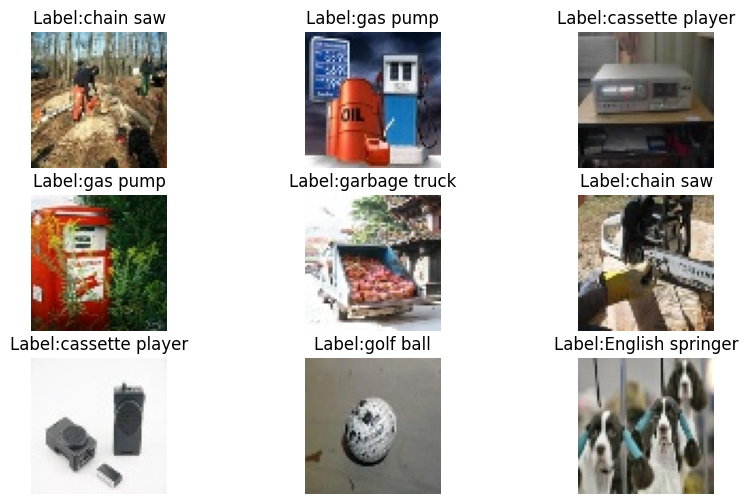

In [13]:
# Plot a few images to check if the labels make sense
plt.figure(figsize=(10, 6))
for n in range(9):
    i = np.random.randint(0, len(train_images), 1)
    ax = plt.subplot(3, 3, n+1)
    plt.imshow(train_images[i[0]])
    plt.title('Label:' + str(label_names[train_labels[i[0]]]))
    plt.axis('off')

## Step1: train a Convolution Neural Network for classification

In [14]:
# define the parameters needed
IMAGE_SHAPE = (64, 64, 3)
OUT_DIM = len(label_names)
BATCH_SIZE = 128
LEARNING_RATE = 1e-4
EPOCHS = 100

In [15]:
# define the model
class CNN_imagenet(Model):
    def __init__(self, n_units):
        super().__init__()
        self.vgg16 = vgg16.VGG16(include_top=False, weights='imagenet',input_shape=IMAGE_SHAPE)
        self.globalaveragepooling2d = GlobalAveragePooling2D()
        self.dense1 = Dense(n_units, activation='relu')
        self.dropout = Dropout(0.25)
        self.dense2 = Dense(256, activation='relu')
        self.dense3 = Dense(OUT_DIM, activation='softmax')

    def call(self, inputs):
        x = self.vgg16(inputs)
        x = self.globalaveragepooling2d(x)
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        x = self.dropout(x)
        x = self.dense3(x)

        return x

In [32]:
cnn_imagenet = CNN_imagenet(n_units=2048)
# initialize the model
cnn_imagenet.build((None,) + IMAGE_SHAPE)
# compile the model
cnn_imagenet.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                loss=SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
cnn_imagenet.summary()

Model: "cnn_imagenet_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 global_average_pooling2d_1  multiple                  0         
 7 (GlobalAveragePooling2D)                                      
                                                                 
 dense_51 (Dense)            multiple                  1050624   
                                                                 
 dropout_17 (Dropout)        multiple                  0         
                                                                 
 dense_52 (Dense)            multiple                  524544    
                                                                 
 dense_53 (Dense)            multiple                  2570      
                                                   

In [18]:
# train 3 models
history_list = []
accuracy_list = []

model_iteration = 3
for i in range(model_iteration):
    # create the model
    cnn_imagenet = CNN_imagenet(n_units=2048)
    # compile the model
    cnn_imagenet.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                    loss=SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])

    print(f'model: {str(i+1)}/{model_iteration}')
    path = os.path.join('sample_data/imagenette/images/', f'weights_{i+1}.h5')

    # define call backs
    callbacks_earlystopping = EarlyStopping(monitor='val_loss', patience=10)
    callbacks_chpt = ModelCheckpoint(filepath=path, mode='auto', save_weights_only=True, save_best_only=True, verbose=1)

    # train the model
    history_cnn = cnn_imagenet.fit(train_images,
                                   train_labels,
                                    epochs=EPOCHS,
                                    batch_size=BATCH_SIZE,
                                    callbacks=[callbacks_earlystopping, callbacks_chpt],
                                    validation_data=(val_images, val_labels))

    history_list.append(history_cnn)
    _, test_accuracy = cnn_imagenet.evaluate(test_images, test_labels)

    accuracy_list.append(test_accuracy)
    print(f'Model: {str(i+1)}/{model_iteration}\tTest Accuracy: {test_accuracy:5.4f}')


model: 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Train on 6060 samples, validate on 1515 samples
Epoch 1/100
6060/6060 [==============================] - ETA: 0s - loss: 1.3575 - accuracy: 0.5340

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 0.65926, saving model to sample_data/imagenette/images/weights_1.h5
6060/6060 [==============================] - 8s 1ms/sample - loss: 1.3575 - accuracy: 0.5340 - val_loss: 0.6593 - val_accuracy: 0.7795
Epoch 2/100
6060/6060 [==============================] - ETA: 0s - loss: 0.6229 - accuracy: 0.7946
Epoch 2: val_loss improved from 0.65926 to 0.49387, saving model to sample_data/imagenette/images/weights_1.h5
6060/6060 [==============================] - 8s 1ms/sample - loss: 0.6229 - accuracy: 0.7946 - val_loss: 0.4939 - val_accuracy: 0.8422
Epoch 3/100
6060/6060 [==============================] - ETA: 0s - loss: 0.3959 - accuracy: 0.8752
Epoch 3: val_loss did not improve from 0.49387
6060/6060 [==============================] - 8s 1ms/sample - loss: 0.3959 - accuracy: 0.8752 - val_loss: 0.5068 - val_accuracy: 0.8455
Epoch 4/100
6060/6060 [==============================] - ETA: 0s - loss: 0.2478 - accuracy: 0.9210
Epoch 4: val_loss did not improv

In [20]:
# select the highest test accuracy
index_best_model = accuracy_list.index(max(accuracy_list))
path_best_model = os.path.join('sample_data/imagenette/images/', f'weights_{index_best_model+1}.h5')

sample_data/imagenette/images/weights_3.h5


In [34]:
# select the model which has the highest test accuracy and define this model as the best model

# select the highest test accuracy
index_best_model = accuracy_list.index(max(accuracy_list))
path_best_model = os.path.join('sample_data/imagenette/images/', f'weights_{index_best_model+1}.h5')
print()
# build the best model
best_cnn = CNN_imagenet(n_units=2048)

# initialize the best model
best_cnn.build((None,) + IMAGE_SHAPE)

# load the weights of the best model
best_cnn.load_weights(path_best_model)

# best model summary
best_cnn.summary()

# use the best model to evaluate the test data
_, best_test_acc = best_cnn.evaluate(train_images, train_labels)

print("Test Accuracy: {0:5.4f}".format(best_test_acc))



Model: "cnn_imagenet_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 global_average_pooling2d_1  multiple                  0         
 9 (GlobalAveragePooling2D)                                      
                                                                 
 dense_57 (Dense)            multiple                  1050624   
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
 dense_58 (Dense)            multiple                  524544    
                                                                 
 dense_59 (Dense)            multiple                  2570      
                                                  

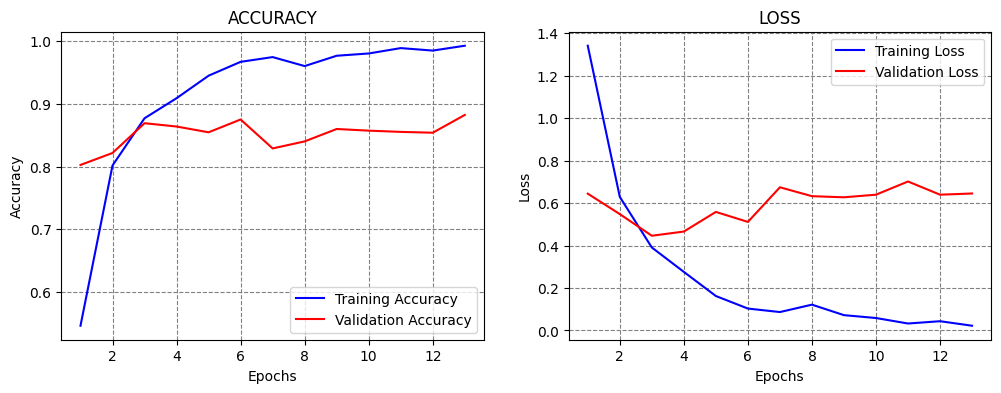

In [36]:
# plot the learning curve
def plot_accuracy_loss(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochsn = np.arange(1, len(train_loss)+1,1)
    plt.figure(figsize=(12, 4))

    plt.subplot(1,2,1)
    plt.plot(epochsn, acc, 'b', label='Training Accuracy')
    plt.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
    plt.grid(color='gray', linestyle='--')
    plt.legend()
    plt.title('ACCURACY')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.subplot(1,2,2)
    plt.plot(epochsn,train_loss, 'b', label='Training Loss')
    plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
    plt.grid(color='gray', linestyle='--')
    plt.legend()
    plt.title('LOSS')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

plot_accuracy_loss(history_list[index_best_model])

## Step2:Randomly Select 100 Test Images and Implement FGSM, PGD and Deep Fool

In [37]:
# randomly select 100 smaples from test images

rand_100 = np.random.choice(len(test_images), size=100)
test_images_100 = test_images[rand_100]
test_labels_100 = test_labels[rand_100]
print('Test image shape: {}\nTest label shape: {}'.format(test_images_100.shape, test_labels_100.shape))

Test image shape: (100, 64, 64, 3)
Test label shape: (100,)


In [39]:
# create the keras classfier
cls_krs = KerasClassifier(model=best_cnn, clip_values=(0,1))

# evaluate the keras classifier on the randomly selected test data
pred_cls_krs = np.argmax(cls_krs.predict(test_images_100), axis=1)
correct_pred = (pred_cls_krs==test_labels_100).sum()
acc_cls_krs = correct_pred/len(test_labels_100)
print("Test Accuracy on 100 Randomly Selected Test Images: %5.4f" %(acc_cls_krs))

Test Accuracy on 100 Randomly Selected Test Images: 0.8300


### 2.1 Generate adversarial images using FGSM

In [40]:
# implement FGSM

# define an instance of FastGradientMethod
fgsm = FastGradientMethod(estimator=cls_krs, eps=10/255)

# produce the adversarial images
fgsm_images = fgsm.generate(test_images_100)

# evaluate the best model on adversarial images
_, fgsm_acc = best_cnn.evaluate(fgsm_images, test_labels_100)

# print the accuracy
print('Accuray on FGSM adversarial images: %5.4f'%fgsm_acc)


Accuray on FGSM adversarial images: 0.2000


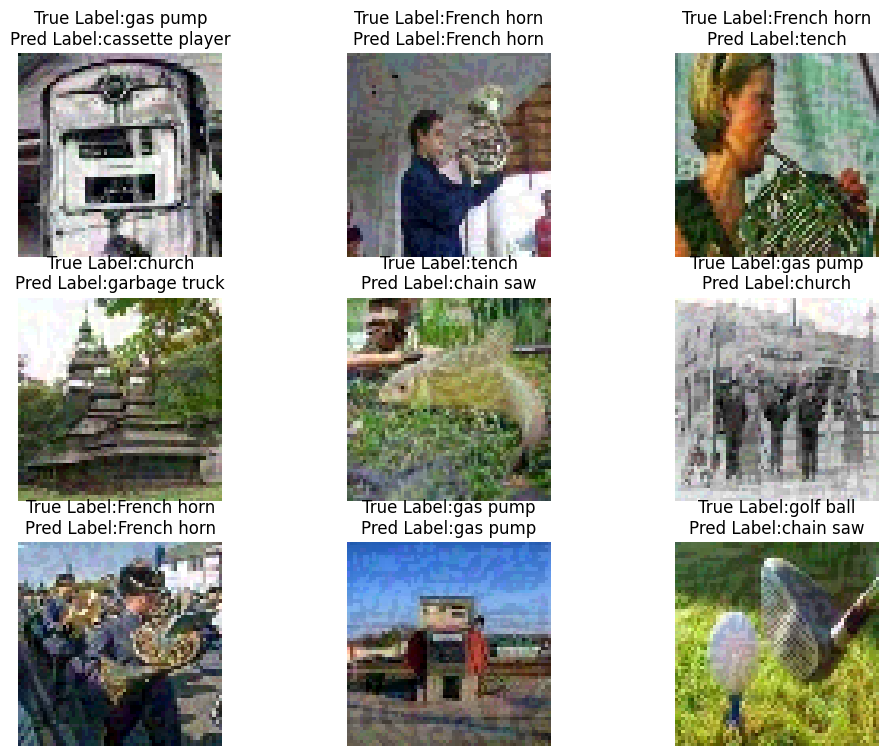

In [43]:
# plot the adversarial FGSM images

plt.figure(figsize=(12,9))

for i in range(9):
    #randomly select an image from test_image_100
    index = np.random.randint(0, len(test_images_100),1)

    # predict the images's label name
    pred_out = best_cnn.predict(fgsm_images[index])
    pred_label = np.argmax(pred_out)
    pred_name = label_names[pred_label]

    # plot the image
    plt.subplot(3, 3, i+1)
    plt.imshow(fgsm_images[index[0]])

    # plot the true label name and the predicted label name
    plt.title("True Label:{}\nPred Label:{}".format(label_names[test_labels_100[index[0]]], pred_name))
    plt.axis('off')

### 2.2 Generate adversarial images using PGD

In [44]:
# implement PGD

# define an instance of ProjectedGradientDescent
pgd = ProjectedGradientDescent(estimator=cls_krs, eps=10/255)

# produce the adversarial images
pgd_images = pgd.generate(test_images_100)

# evaluate the best model on adversarial images
_, pgd_acc = best_cnn.evaluate(pgd_images, test_labels_100)

# print the accuracy
print('Accuray on FGSM adversarial images: %5.4f'%pgd_acc)

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Accuray on FGSM adversarial images: 0.2300


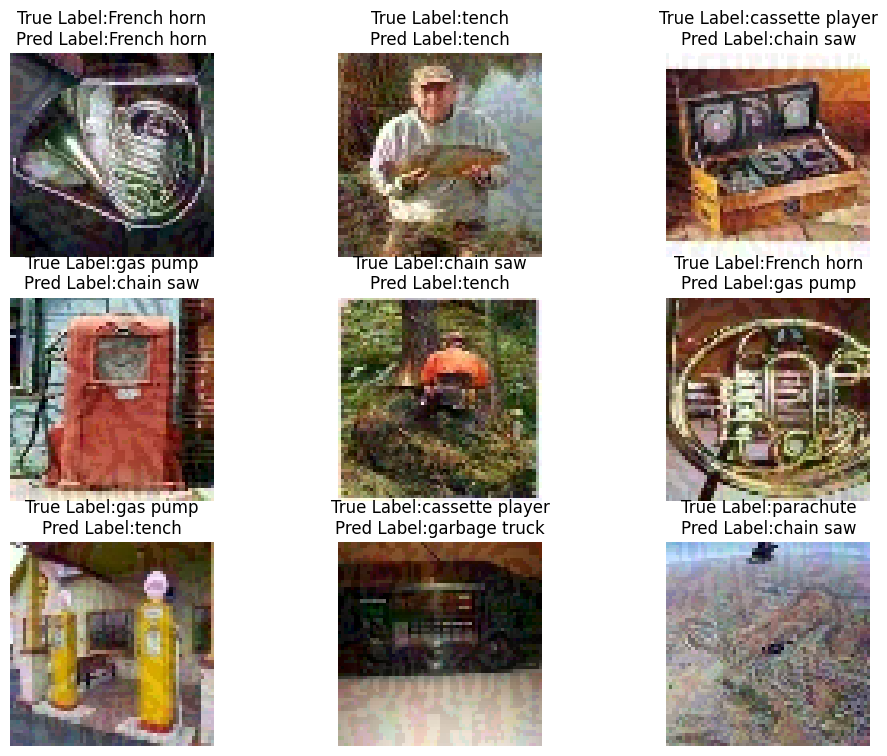

In [45]:
# plot the adversarial PGD images

plt.figure(figsize=(12,9))

for i in range(9):
    #randomly select an image from test_image_100
    index = np.random.randint(0, len(test_images_100),1)

    # predict the images's label name
    pred_out = best_cnn.predict(pgd_images[index])
    pred_label = np.argmax(pred_out)
    pred_name = label_names[pred_label]

    # plot the image
    plt.subplot(3, 3, i+1)
    plt.imshow(pgd_images[index[0]])

    # plot the true label name and the predicted label name
    plt.title("True Label:{}\nPred Label:{}".format(label_names[test_labels_100[index[0]]], pred_name))
    plt.axis('off')

### 2.3 Generate adversarial images using Deep Fool

In [48]:
# implement Deep Fool

# define an instance of ProjectedGradientDescent
df = DeepFool(classifier=cls_krs, max_iter=50)

# produce the adversarial images
df_images = df.generate(test_images_100)

# evaluate the best model on adversarial images
_, df_acc = best_cnn.evaluate(df_images, test_labels_100)

# print the accuracy
print('Accuray on FGSM adversarial images: %5.4f'%df_acc)

DeepFool:   0%|          | 0/100 [00:00<?, ?it/s]

Accuray on FGSM adversarial images: 0.1400


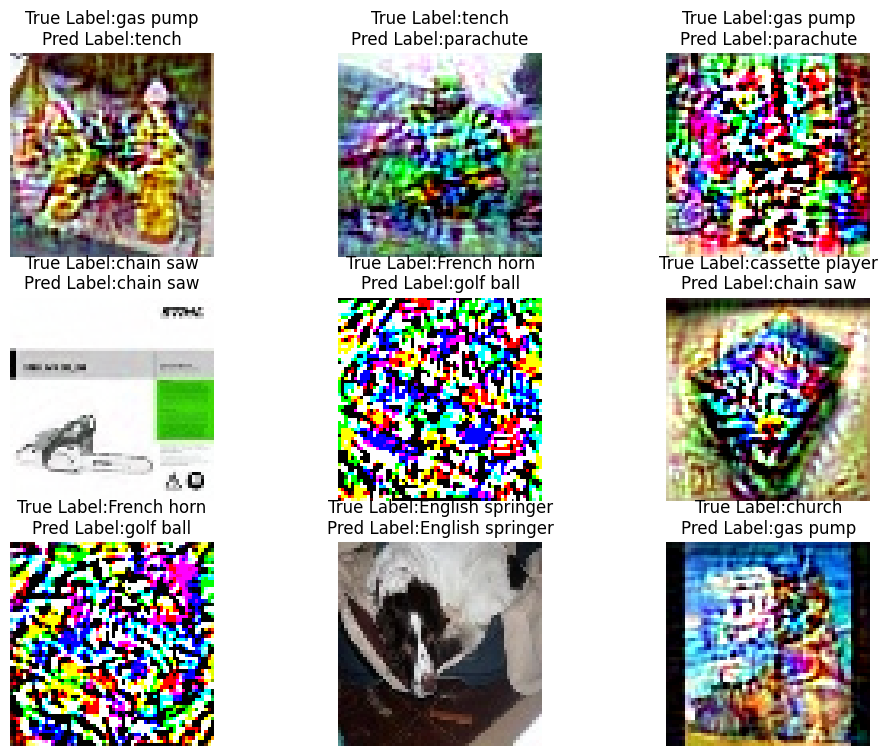

In [49]:
# plot the adversarial Deep Fool images

plt.figure(figsize=(12,9))

for i in range(9):
    #randomly select an image from test_image_100
    index = np.random.randint(0, len(test_images_100),1)

    # predict the images's label name
    pred_out = best_cnn.predict(df_images[index])
    pred_label = np.argmax(pred_out)
    pred_name = label_names[pred_label]

    # plot the image
    plt.subplot(3, 3, i+1)
    plt.imshow(df_images[index[0]])

    # plot the true label name and the predicted label name
    plt.title("True Label:{}\nPred Label:{}".format(label_names[test_labels_100[index[0]]], pred_name))
    plt.axis('off')

## Step3:Adversarial Training and Evaluate the Trained Classifier

### 3.1 Adversarial Training

In [53]:
# create another keras classifier for adversarial training
cls_ad_training = KerasClassifier(model=best_cnn, clip_values=(0,1), use_logits=False)

# define the adversarial attack
atk_ad_training = fgsm

# define the defense model
model_ad_defense = AdversarialTrainer(cls_ad_training, atk_ad_training, ratio=0.5)

# train the defense model
model_ad_defense.fit(train_images, train_labels, nb_epochs=20, batch_size=128)

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

### 3.2 Evaluate the Trained Classifier on Adversarial Images

In [55]:
# evaluate the defense model on train images

pred_out_tr = model_ad_defense.predict(train_images)
pred_label_tr = np.argmax(pred_out_tr, axis=1)
pre_correct_tr = np.sum(pred_label_tr==train_labels)

pre_acc_tr = pre_correct_tr/len(train_labels)

print("Adversarial Training Accuracy on Clean Training Images: %5.4f"%pre_acc_tr)

Adversarial Training Accuracy on Clean Training Images: 1.0000


In [60]:
# evaluate the defense model on test images

pred_out_test = model_ad_defense.predict(test_images)
pred_label_test = np.argmax(pred_out_test, axis=1)
pre_correct_test = np.sum(pred_label_test==test_labels)

pre_acc_test = pre_correct_test/len(test_labels)

print("Adversarial Training Accuracy on Clean Training Images: %5.4f"%pre_acc_test)

Adversarial Training Accuracy on Clean Training Images: 0.8194


In [56]:
# evaluate the defense model on randomly selected test images test_images_100

pred_out_100 = model_ad_defense.predict(test_images_100)
pred_label_100 = np.argmax(pred_out_100,axis=1)
pre_correct_100 = np.sum(pred_label_100==test_labels_100)

pre_acc_100 = pre_correct_100/len(test_labels_100)

print("Adversarial Training Accuracy on Clean Training Images: %5.4f"%pre_acc_100)

Adversarial Training Accuracy on Clean Training Images: 0.7800


In [57]:
# evaluate the defense model on FGSM adversarial images

pred_out_fgsm = model_ad_defense.predict(fgsm_images)
pred_label_fgsm = np.argmax(pred_out_fgsm,axis=1)
pre_correct_fgsm = np.sum(pred_label_fgsm==test_labels_100)

pre_acc_fgsm = pre_correct_fgsm/len(test_labels_100)

print("Adversarial Training Accuracy on Clean Training Images: %5.4f"%pre_acc_fgsm)

Adversarial Training Accuracy on Clean Training Images: 0.7600


In [58]:
# evaluate the defense model on PGD adversarial images

pred_out_pgd = model_ad_defense.predict(pgd_images)
pred_label_pgd = np.argmax(pred_out_pgd,axis=1)
pre_correct_pgd = np.sum(pred_label_pgd==test_labels_100)

pre_acc_pgd = pre_correct_pgd/len(test_labels_100)

print("Adversarial Training Accuracy on Clean Training Images: %5.4f"%pre_acc_pgd)

Adversarial Training Accuracy on Clean Training Images: 0.7800


In [59]:
# evaluate the defense model on Deep Fool adversarial images

pred_out_df = model_ad_defense.predict(df_images)
pred_label_df = np.argmax(pred_out_df,axis=1)
pre_correct_df = np.sum(pred_label_df==test_labels_100)

pre_acc_df = pre_correct_df/len(test_labels_100)

print("Adversarial Training Accuracy on Clean Training Images: %5.4f"%pre_acc_df)

Adversarial Training Accuracy on Clean Training Images: 0.4200


## Step4: Report

In [67]:
print('{0:=<8} | {1:-^10} | {2:.>8}'.format('Left','Center','Right'))

Left==== | --Center-- | ...Right


In [86]:
print('{0:-^20}|{1:-^20}|{2:-^20}|{3:-^20}|{4:-^20}|{5:-^20}'.format('Model',
                                                            'Test Accuracy',
                                                             'Subset_100 Accuracy',
                                                            'FGSM_100 Accuracy',
                                                            'PGD_100 Accuracy',
                                                            'DF_100 Accuracy'))
print('{0:^20}|{1:^20.4f}|{2:^20.4f}|{3:^20.4f}|{4:^20.4f}|{5:^20.4f}'.format('Standard Model',
                                                              best_test_acc,
                                                             acc_cls_krs,
                                                            fgsm_acc,
                                                            pgd_acc,
                                                            df_acc))
print('{0:^20}|{1:^20.4f}|{2:^20.4f}|{3:^20.4f}|{4:^20.4f}|{5:^20.4f}'.format('Adv_trained Model',
                                                              pre_acc_test,
                                                             pre_acc_100,
                                                            pre_acc_fgsm,
                                                            pre_acc_pgd,
                                                            pre_acc_df))

-------Model--------|---Test Accuracy----|Subset_100 Accuracy-|-FGSM_100 Accuracy--|--PGD_100 Accuracy--|--DF_100 Accuracy---
   Standard Model   |       0.9259       |       0.8300       |       0.2000       |       0.2300       |       0.1400       
 Adv_trained Model  |       0.8194       |       0.7800       |       0.7600       |       0.7800       |       0.4200       


**Discussion:**

in this assignment, We didn't change the pertubation size, we used pertubation 10/255. Based on the previous assignments, 10/255 is not a large pertubation. So in adversarial training, I trained the defense model for 20 epochs and to get a 0.7600 accuracy on FGSM attacked images, 0.7800 accuracy on PGD attacked images and 0.4200 accuracy on Deep Fool attacked images. 

I think if the pertubation size is larger, we need more adversarial training to get higher accuracy on adversarially attacked images. I think it is also true larger pertubation need more adversarial training for FGSM and PGD attacked samples.